In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

In [24]:
#Loading the dataset
data=pd.read_csv('bank-additional-full.csv',sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Dealing with Duplicate Data

In [25]:
data_dup = data[data.duplicated(keep="last")]
data_dup

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20072,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20531,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25183,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [26]:
data_dup.shape

(12, 21)

In [27]:
data = data.drop_duplicates()
data.shape

(41176, 21)

## Separating Explanatory and Target Variables

In [28]:
data_x = data.iloc[:, :-1]
print("Shape of X:", data_x.shape)
data_y = data["y"]
print("Shape of Y:", data_y.shape)

Shape of X: (41176, 20)
Shape of Y: (41176,)


## Splitting Train and Test Dataset

In [29]:
from sklearn.model_selection import train_test_split

X_rest, X_test, y_rest, y_test = train_test_split(data_x, data_y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_rest, y_rest, test_size=0.2)

print("X Train:", X_train.shape)
print("X CV:", X_cv.shape)
print("X Test:", X_test.shape)
print("Y Train:", y_train.shape)
print("Y CV:", y_cv.shape)
print("Y Test:", y_test.shape)

X Train: (26352, 20)
X CV: (6588, 20)
X Test: (8236, 20)
Y Train: (26352,)
Y CV: (6588,)
Y Test: (8236,)


In [30]:
# Replace "no" with 0 and "yes" with 1

y_train.replace({"no":0, "yes":1}, inplace=True)
y_cv.replace({"no":0, "yes":1}, inplace=True)
y_test.replace({"no":0, "yes":1}, inplace=True)

## ENCODING CATEGORICAL FEATURES

## One-Hot Encoding Categorical Features

In [31]:
# Categorical boolean mask
categorical_feature_mask = data_x.dtypes==object

# filter categorical columns using mask and turn it into a list
categorical_cols = data_x.columns[categorical_feature_mask].tolist()

In [32]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

def add_onehot_to_dataframe(sparse, df, vectorizer, name):
  '''
      This function will add the one hot encoded to the dataframe.

  '''
  for i, col in enumerate(vectorizer.get_feature_names()):
    colname = name+"_"+col
    # df[colname] = pd.SparseSeries(sparse[:, i].toarray().flatten(), fill_value=0)
    df[colname] = sparse[:, i].toarray().ravel().tolist()
  
  return df

def OneHotEncoder(categorical_cols, X_train, X_test, X_cv=None, include_cv=False):
  '''
    This function takes categorical column names as inputs. The objective
    of this function is to take the column names iteratively and encode the 
    features using One hot Encoding mechanism and also adding the encoded feature
    to the respective dataframe.

    The include_cv parameter indicates whether we should include CV dataset or not.
    This is added specifically because when using GridSearchCV or RandomizedSearchCV,
    we only split the dataset into train and test to give more data to training purposes.
    This is done because GridSearchCV splits the data internally anyway.
  '''

  for i in categorical_cols:
    Vectorizer = CountVectorizer(token_pattern="[A-Za-z0-9-.]+")
    print("Encoding for feature: ", i)
    # Encoding training dataset 
    temp_cols = Vectorizer.fit_transform(X_train[i])
    X_train = add_onehot_to_dataframe(temp_cols, X_train, Vectorizer, i)

    # Encoding Cross validation dataset
    if include_cv:
      temp_cols = Vectorizer.transform(X_cv[i])
      X_cv = add_onehot_to_dataframe(temp_cols, X_cv, Vectorizer, i)

    # Encoding Test dataset
    temp_cols = Vectorizer.transform(X_test[i])
    X_test = add_onehot_to_dataframe(temp_cols, X_test, Vectorizer, i)

In [34]:
OneHotEncoder(categorical_cols, X_train, X_test, X_cv, True)

# Drop the categorical features as the one hot encoded representation is present
X_train = X_train.drop(categorical_cols, axis=1)
X_cv = X_cv.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)

print("Shape of train: ", X_train.shape)
print("Shape of CV: ", X_cv.shape)
print("Shape of test: ", X_test.shape)

Encoding for feature:  job
Encoding for feature:  marital
Encoding for feature:  education
Encoding for feature:  default
Encoding for feature:  housing
Encoding for feature:  loan
Encoding for feature:  contact
Encoding for feature:  month
Encoding for feature:  day_of_week
Encoding for feature:  poutcome
Shape of train:  (26352, 63)
Shape of CV:  (6588, 63)
Shape of test:  (8236, 63)


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26352 entries, 3627 to 17017
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            26352 non-null  int64  
 1   duration                       26352 non-null  int64  
 2   campaign                       26352 non-null  int64  
 3   pdays                          26352 non-null  int64  
 4   previous                       26352 non-null  int64  
 5   emp.var.rate                   26352 non-null  float64
 6   cons.price.idx                 26352 non-null  float64
 7   cons.conf.idx                  26352 non-null  float64
 8   euribor3m                      26352 non-null  float64
 9   nr.employed                    26352 non-null  float64
 10  job_admin.                     26352 non-null  int64  
 11  job_blue-collar                26352 non-null  int64  
 12  job_entrepreneur               26352 non-nu

In [36]:
# Removing duration feature 

# From Train
X_train = X_train.drop("duration", axis=1)
print("The shape of the train dataset: ", X_train.shape)

# From CV
X_cv = X_cv.drop("duration", axis=1)
print("The shape of the cv dataset: ", X_cv.shape)

# From Test
X_test = X_test.drop("duration", axis=1)
print("The shape of the test dataset: ", X_test.shape)

The shape of the train dataset:  (26352, 62)
The shape of the cv dataset:  (6588, 62)
The shape of the test dataset:  (8236, 62)


## MODELLING THE DATA USING LINEAR SVM

In [37]:
# train the model on train set
model = SVC(kernel="linear")
model.fit(X_train, y_train)
  
# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7263
           1       0.60      0.19      0.29       973

    accuracy                           0.89      8236
   macro avg       0.75      0.59      0.62      8236
weighted avg       0.87      0.89      0.86      8236



In [38]:
from sklearn import metrics
print("AUC score: ", metrics.roc_auc_score(y_test, predictions))

AUC score:  0.5880720100853288


AUC for alpha =  1e-05 is 0.5
AUC for alpha =  0.0001 is 0.5
AUC for alpha =  0.001 is 0.7649792942975926
AUC for alpha =  0.01 is 0.7643188968736307
AUC for alpha =  0.1 is 0.7611591706561319
AUC for alpha =  1 is 0.759046642747309
AUC for alpha =  10 is 0.7276346451787618
AUC for alpha =  100 is 0.6563333414691692
AUC for alpha =  1000 is 0.42730026232259516


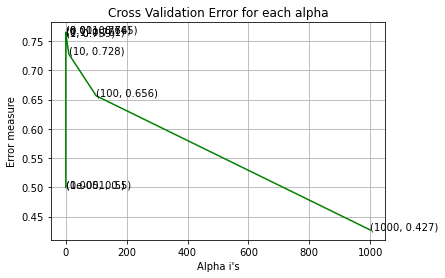

For values of best alpha =  0.001 The train AUC is: 0.753618875221421
For values of best alpha =  0.001 The cross validation AUC is: 0.7639348854183736
For values of best alpha =  0.001 The test AUC is: 0.7820273078757741


In [39]:
%matplotlib inline

alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    linearSVM = SGDClassifier(penalty='l2',alpha=i,class_weight='balanced')
    linearSVM.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(linearSVM, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for alpha = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

linearSVM = SGDClassifier(penalty='l2', alpha=alpha[best_alpha], class_weight='balanced')
linearSVM.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(linearSVM, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

## RBF

AUC for C =  1e-05 is 0.753315527475299
AUC for C =  0.0001 is 0.753315527475299
AUC for C =  0.001 is 0.753315527475299
AUC for C =  0.01 is 0.753315527475299
AUC for C =  0.1 is 0.7601803133691543
AUC for C =  1 is 0.7659032928052478
AUC for C =  10 is 0.7700462929063647
AUC for C =  100 is 0.774683254473838
AUC for C =  1000 is 0.778601240598751


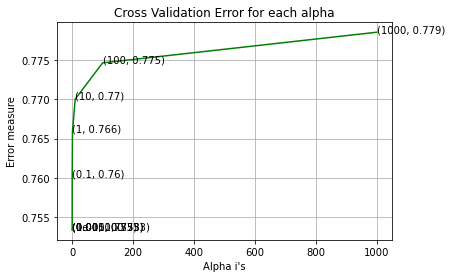

For values of best alpha =  1000 The train AUC is: 0.7655470816176526
For values of best alpha =  1000 The cross validation AUC is: 0.778601240598751
For values of best alpha =  1000 The test AUC is: 0.7954534230643455


In [40]:
%matplotlib inline
from sklearn.svm import SVC

alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    SVM = SVC(C=i,class_weight='balanced')
    SVM.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(SVM, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for C = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
for i, txt in enumerate(np.round(cv_auc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_auc_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

SVM = SVC(C=alpha[best_alpha], class_weight='balanced')
SVM.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(SVM, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))
